In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
class MultiClassSVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassSVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes,bias=False)

    def forward(self, x):
        return self.linear(x)
    
def hinge_loss(outputs, labels):
    num_classes = outputs.size(1)
    correct_indices = labels.view(-1, 1)
    correct_scores = outputs.gather(1, correct_indices)
    margins = torch.clamp(1 - (correct_scores - outputs), min=0)
    margins.scatter_(1, correct_indices, 0)
    loss = margins.mean()
    return loss

def train(
    model,
    train_loader,    
    ):
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data.float())
        loss = hinge_loss(output, target)
        loss.backward()
        _, argmax = torch.max(output, 1)
        accuracy = (target == argmax.squeeze()).float().mean()
        print("accuracy is",accuracy)


In [ ]:
svm = MultiClassSVM(input_size=28,num_classes=10)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.PILToTensor(),
                
            ]
        ),
        
    ),
    batch_size=64,
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.PILToTensor(),
                
            ]
        ),
    ),
    batch_size=64,
)
train(svm,train_loader)

In [291]:
import numpy as np
import os
data = np.load('E:/ASU/Norse/w1.npy')
print(data)

[[[[0.9525311  0.99800354 0.99934125 0.99798566 0.9515599 ]
   [0.9799932  0.99942476 0.99978733 0.9993262  0.9917967 ]
   [0.9881643  0.9996576  0.99992037 0.99966073 0.9882093 ]
   [0.98207396 0.9991504  0.999947   0.99950945 0.9814463 ]
   [0.95909053 0.9977498  0.999218   0.9975468  0.97772783]]]


 [[[0.93692946 0.99736077 0.9995622  0.99660635 0.9491777 ]
   [0.9709373  0.9993761  0.9997428  0.9991455  0.973812  ]
   [0.98342204 0.9996263  0.99996954 0.9996327  0.98257935]
   [0.9738532  0.9995629  0.99982554 0.99894714 0.9763769 ]
   [0.9584246  0.9960793  0.9993281  0.99696773 0.94919723]]]


 [[[0.9734066  0.99778575 0.9997628  0.9979829  0.97497237]
   [0.9864244  0.9991548  0.99984574 0.999496   0.99063754]
   [0.9880298  0.9997816  0.99973756 0.99977326 0.98999935]
   [0.9892874  0.9993695  0.9997157  0.999329   0.99228716]
   [0.9665115  0.9970384  0.999536   0.9989144  0.97897804]]]


 [[[0.96018165 0.9965979  0.9995185  0.9957422  0.95140207]
   [0.97174275 0.99950796 0.

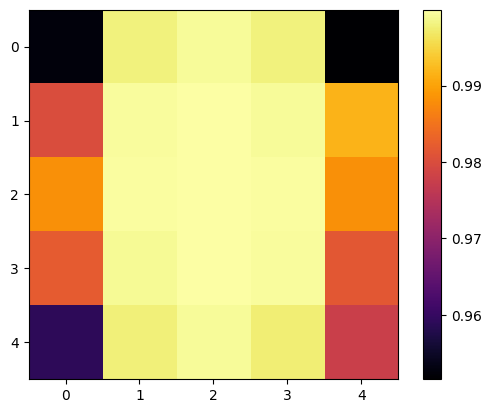

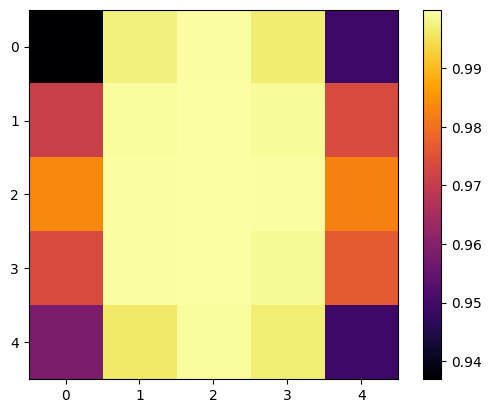

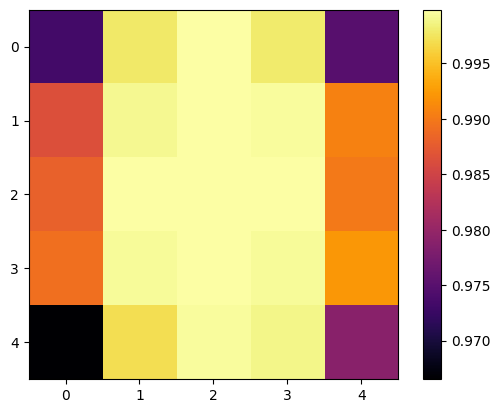

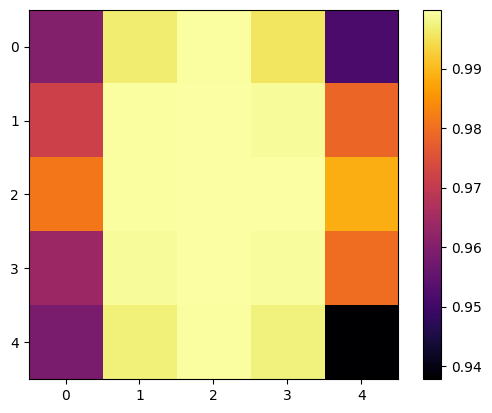

In [292]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(data.shape[0]):
    plt.imshow(data[i,0], cmap='inferno', interpolation='nearest')
    plt.colorbar()  # 添加颜色条
    plt.show()
